### 0719 DOING frame consistency

## ELAN Evaluation metrics (Dim delta, depth, alpha, Dim consistency)

In [16]:
from library.ron_utils import *
import matplotlib.pyplot as plt
from library.ron_utils import iou_2d, DetectedObject
from ELAN_label_trackID import tracking_obj_by_labels

'''
cam_to_img = np.array([
        [ 1.418667e+03, 0.000000e+00, 6.4e+02,0],
        [ 0.000000e+00, 1.418667e+03, 3.6e+02,0],
        [ 0.000000e+00, 0.000000e+00, 1.000000e+00,0]])
'''

def ELAN_eval_metrics(result_root):
    valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]
    dim_GT = list()
    dim_ELAN = list()
    depth_GT = list()
    depth_ELAN = list()
    alpha_GT = list()
    alpha_ELAN = list()

    for id_ in valset:
        gt_lines = [x.strip() for x in open(f'Elan_3d_box/renew_label/{id_}.txt').readlines()]
        gt_objects = [DetectedObject(line) for line in gt_lines if line.split()[0]=='Car']
        for obj in gt_objects:
            dim_GT.append(obj.dims[0])
            depth_GT.append(obj.locs[0][2])
            alpha_GT.append(obj.alphas[0])
            
        pred_lines = [x.strip() for x in open(f'{result_root}/{id_}.txt').readlines()]
        pred_objects = [DetectedObject(line) for line in pred_lines if line.split()[0]=='Car']
        for obj in pred_objects:
            dim_ELAN.append(obj.dims[0])
            depth_ELAN.append(obj.locs[0][2])
            alpha_ELAN.append(obj.alphas[0])

    dim_GT = np.array(dim_GT)
    dim_ELAN = np.array(dim_ELAN)
    depth_GT = np.array(depth_GT)
    depth_ELAN = np.array(depth_ELAN)
    alpha_GT = np.array(alpha_GT)
    alpha_ELAN = np.array(alpha_ELAN)

    depth_diff = depth_GT-depth_ELAN
    alpha_diff = np.cos(alpha_GT - alpha_ELAN)
    dim_diff = np.mean(abs(dim_GT-dim_ELAN), axis=0)
    print(f'[DIM diff] H:{dim_diff[0]:.4f}, W:{dim_diff[1]:.4f}, L:{dim_diff[2]:.4f}')
    
    print(f'[Alpha diff] abs_mean: {alpha_diff.mean():.4f}')
    plt.hist(alpha_diff)
    plt.show()
    print(f'[Depth diff] abs_mean: {abs(depth_diff).mean():.4f}')
    print('[Depth error]')
    box_depth_error_calculation(depth_GT, depth_ELAN, 5)

[DIM diff] H:0.1903, W:0.1478, L:0.5493
[Alpha diff] abs_mean: 0.7549


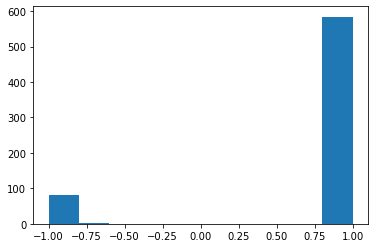

[Depth diff] abs_mean: 4.6484
[Depth error]
num of Car: 665
	num of depth 0-10: 0 
	num of depth 10-20: 68   abs_delta mean:2.900m, Out of 5m: 11
	num of depth 20-30: 142   abs_delta mean:3.744m, Out of 5m: 40
	num of depth 30-40: 259   abs_delta mean:3.976m, Out of 5m: 75
	num of depth 40-50: 95   abs_delta mean:7.061m, Out of 5m: 49
	num of depth 50-60: 50   abs_delta mean:6.514m, Out of 5m: 27
	num of depth 60+: 51     abs_delta mean:6.587m, Out of 5m: 28
[Total] mean:4.648, std:4.591

||||||||||||||||||||||||||||||||||||||||

[DIM diff] H:0.2203, W:0.1630, L:0.6798
[Alpha diff] abs_mean: 0.7756


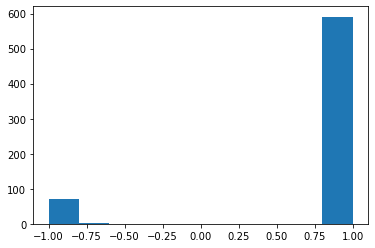

[Depth diff] abs_mean: 4.8879
[Depth error]
num of Car: 665
	num of depth 0-10: 0 
	num of depth 10-20: 68   abs_delta mean:3.051m, Out of 5m: 11
	num of depth 20-30: 142   abs_delta mean:3.759m, Out of 5m: 40
	num of depth 30-40: 259   abs_delta mean:4.236m, Out of 5m: 86
	num of depth 40-50: 95   abs_delta mean:6.680m, Out of 5m: 50
	num of depth 50-60: 50   abs_delta mean:8.237m, Out of 5m: 29
	num of depth 60+: 51     abs_delta mean:7.166m, Out of 5m: 29
[Total] mean:4.888, std:4.540


In [17]:
ELAN_eval_metrics('ELAN_video')
print()
print('||'*20)
print()
ELAN_eval_metrics('0720_BL')

## Eval result : improvement of objects

In [44]:
import glob
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
valset = [x.strip() for x in open('Elan_3d_box/ImageSets/val.txt').readlines()]

val_images = sorted(glob.glob('Elan_3d_box/image_2/*.png'))[-1*len(valset):] 
GT_labels = sorted(glob.glob('Elan_3d_box/renew_label/*.txt'))[-1*len(valset):]
V_labels = sorted(glob.glob('ELAN_video/*.txt'))[-1*len(valset):]
BL_labels = sorted(glob.glob('ELAN_BL/*.txt'))[-1*len(valset):]
assert len(valset) == len(V_labels), 'video_label length diff'
assert len(valset) == len(BL_labels), 'BL_label length diff'

GT_tracking_dict = tracking_obj_by_labels(GT_labels, val_images, WRITE_FILE=False)
V_tracking_dict = tracking_obj_by_labels(V_labels, val_images, WRITE_FILE=False)
BL_tracking_dict = tracking_obj_by_labels(BL_labels, val_images, WRITE_FILE=False)

0
500
0
500
0
500


In [45]:
other_count = 0

dim_GT_1 = list()
dim_V_1 = list()
dim_BL_1 = list()

dim_GT_f = list()
dim_V_f = list()
dim_BL_f = list()

classes = ['motor', 'bus', 'car']
for key in GT_tracking_dict.keys():
    GT_obj = GT_tracking_dict[key]
    V_obj = V_tracking_dict[key]
    BL_obj = BL_tracking_dict[key]
    if GT_obj.class_.lower() != 'car':
        other_count += 1
        continue
    if (V_obj.box2d != BL_obj.box2d).all() or (V_obj.box2d != GT_obj.box2d).all() or (GT_obj.box2d != BL_obj.box2d).all():
        print('Box 2D diff:', key)
        break
        
    if len(GT_obj.frames) == 1:
        dim_GT_1.append(GT_obj.dims[0])
        dim_V_1.append(V_obj.dims[0])
        dim_BL_1.append(BL_obj.dims[0])
    else:
        dim_GT_f += GT_obj.dims
        dim_V_f += V_obj.dims
        dim_BL_f += BL_obj.dims
            

In [55]:
print(dim_GT_1.shape)
print(dim_GT_f.shape)
trainset = [x.strip() for x in open('Elan_3d_box/ImageSets/train.txt').readlines()]
print(len(trainset))
print(len(valset))
1591+682

(80, 3)
(586, 3)
1591
682


2273

In [47]:
dim_GT_1 = np.array(dim_GT_1)
dim_V_1 = np.array(dim_V_1)
dim_BL_1 = np.array(dim_BL_1)
dim_GT_f = np.array(dim_GT_f)
dim_V_f = np.array(dim_V_f)
dim_BL_f = np.array(dim_BL_f)

V_dim_diff_1 = np.mean(abs(dim_GT_1 - dim_V_1), axis=0)
BL_dim_diff_1 = np.mean(abs(dim_GT_1 - dim_BL_1), axis=0)
print(V_dim_diff_1)
print(BL_dim_diff_1)

V_dim_diff_f = np.mean(abs(dim_GT_f - dim_V_f), axis=0)
BL_dim_diff_f = np.mean(abs(dim_GT_f - dim_BL_f), axis=0)
print(V_dim_diff_f)
print(BL_dim_diff_f)

[0.1775   0.200875 0.6305  ]
[0.211875 0.200125 0.78475 ]
[0.19448805 0.14117747 0.54849829]
[0.21143345 0.15583618 0.70049488]
